In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

In [2]:
#ASO lidar - netCDFs & integers in [mm]
ars_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent_data_downsize/nc/20*/*int.nc'
bsu_path = '/Users/meganmason491/Documents/research/sierra/data/mm/20*/*int.nc'
sonic_path = '/home/meganmason/Research/Sierra/data/mm/20*/*int.nc'

#DEM & Mask for Tuolumne (topo.nc @ 3m cell size) - dem here is from national database...(10m>3m)
ars_topo_path = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc'
bsu_topo_path = '/Users/meganmason491/Documents/research/sierra/data/topo.nc'
sonic_topo_path = '/home/meganmason/Research/Sierra/data/topo.nc'

# ASO snow-free and surface class
ars_terrain_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/*.nc'
# bsu_terrain_path = ''
# sonic_terrain_path = ''


# ~~ SET PATH HERE ~~ #
path = ars_path
topo_path = ars_topo_path
terrain_path = ars_terrain_path

In [3]:
#filepath list, lidar
flist = sorted(glob.glob(path))

# Parse dates, store as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splits fname on '_' saves first

# flight dates, parsed from filename
dates = pd.to_datetime(fparse) #pandas datetime variable, lidar dates

In [4]:
# '''peak snow depth dates....(?)'''
# flist = list(flist[i] for i in (0,7,22,28,41,49))
# dates = list(dates[i] for i in (0,7,22,28,41,49))

In [5]:
#load xarray, via multiple files
ds=xr.open_mfdataset(flist, concat_dim='time', combine='nested', chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'snow'})
ds.close()

ds = ds.drop('transverse_mercator') #remove
# ds=ds.astype(np.int16, copy=False) #cast as int16 (32,767)
ds['time'] = (['time'], dates) #add 'time' coordinate, default populates with dimension called 'time'
ds


<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 1000, 1000)>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.2.3, released 2017/11/20
    history:             Wed Sep 25 11:53:07 2019: GDAL CreateCopy( /home/meg...

In [6]:
#flip 'y' axis
ds=np.flip(ds.snow,1) 
ds=ds.to_dataset()
ds

#NOTE:
#use np flip
    #where 1=horizontally (even though flip is vert, must be due to (y,x)??)
    #Returns dataArray
    #convert back to DataSet

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 2, 1000)>

In [ ]:
# imshow 'flipped' image

plt.imshow(ds.snow[5])
plt.colorbar()
plt.show()

#gets rid of zeros
# d = np.where(ds.snow[5].values>0, ds.snow[5].values, np.nan)
# plt.imshow(d/1000, vmax=5)

#use isel()
# plt.imshow(ds.isel(time=1).snow)

In [ ]:
#alternative way (doesn't need to be flipped)
# plt.contourf(ds.snow[0]/1000, vmax=5)
# plt.show()

#### Add TOPO.NC (dem, mask, veg_height)

In [8]:
# open topo.nc
topo = xr.open_dataset(topo_path, drop_variables=['veg_tau','veg_k','veg_type','projection'], chunks={'x':1000, 'y':1000})
topo.close()
topo

<xarray.Dataset>
Dimensions:     (x: 17569, y: 17002)
Coordinates:
  * y           (y) float32 4230327.0 4230324.0 ... 4179327.0 4179324.0
  * x           (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
Data variables:
    veg_height  (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem         (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    mask        (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    last_modified:       [2019-08-08 17:17:16] Data added or updated
    Conventions:         CF-1.6
    dateCreated:         2019-08-08 17:17:34
    Title:               Topographic Images for SMRF/AWSM
    history:             [2019-08-08 17:17:34] Create netCDF4 file using Basi...
    institution:         USDA Agricultural Research Service, Northwest Waters...
    generation_command:  /usr/local/bin/basin_setup -f corrected_tuolumne_sub...

In [ ]:
# #flipping topo - this works, but result is "whole" ds is upside down. Plot with imshow(data, origin='lower')
# mud=np.flip(topo.mask,axis=0)
# mud.to_dataset()
# mud
# # plt.imshow(mud)
# #add topo features to lidar DataSet (ds)
# ds['mask'] = (['y','x'],np.flip(topo.mask, axis=0))
# ds['dem'] = (['y','x'],np.flip(topo.dem, axis=0)
# ds['veg'] = (['y','x'],np.flip(topo.veg_height, axis=0)

In [9]:
#add topo features to lidar DataSet (ds)
# ds['mask'] = (['y','x'],topo.mask)
ds['dem'] = (['y','x'],topo.dem)
ds['veg'] = (['y','x'],topo.veg_height)

In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 2, 1000)>
    dem      (y, x) float32 2633.369 2635.3313 2635.3313 ... 3064.8484 3064.3577
    veg      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 17.5 17.5 17.5 17.5 17.5

In [ ]:
plt.imshow(ds.dem.where(ds.mask==1))
plt.colorbar()
plt.title('Tuolumne DEM with mask==1')
plt.show()

In [ ]:
# plot snow with mask (up/down issue)
plt.imshow(ds.snow[0].where(ds.mask==1))
# plt.imshow(ds.snow[0].where(ds.mask==1), origin='lower')
plt.colorbar()
plt.title('snow when mask==1')
plt.show()

#### DataSet where Mask==1 (fail....)

In [10]:
# ds['time'] = (['time'], dates)
# ds['mask1'] = (['mask1'], ds.mask==1)
# ds
# dss=np.where(ds.mask==1)
# dss
# ds = ds.assign_coords(mask=ds.mask)
ds = ds.assign_coords(mask=topo.mask)
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 2, 1000)>
    dem      (y, x) float32 2633.369 2635.3313 2635.3313 ... 3064.8484 3064.3577
    veg      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 17.5 17.5 17.5 17.5 17.5

In [ ]:
ds

In [11]:
# ds(ds.sel(mask='1'))
ds=ds.where(ds.mask==1)

# plt.imshow(ds.mask)

In [17]:
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(51, 17002, 17569), chunksize=(1, 2, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>

In [ ]:
# dss = xr.Variable('snow', ds.snow).astype(np.int16, copy=False) #froze computer!
# dss=ds.variable(ds.snow).astype(np.int16, copy=False)
# dss

In [ ]:
plt.imshow(ds.snow[0], cmap='jet')

In [ ]:
plt.imshow(ds.dem, cmap='jet')

In [ ]:
plt.imshow(ds.veg, cmap='jet')

In [ ]:
ds.to_netcdf('~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc')

#### test terrain layers

In [5]:
flist_terrain = sorted(glob.glob(terrain_path))
flist_terrain

['/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/aspect.nc',
 '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/hillshade.nc',
 '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/roughness.nc',
 '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/slope.nc',
 '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/surface_classification.nc']

In [9]:
terrain = xr.open_dataset(flist_terrain[0]).rename({'Band1':'aspect'}) #, concat_dim='time', combine='nested', chunks={'x':1000, 'y':1000}, parallel=True)
terrain

<xarray.Dataset>
Dimensions:              (x: 17569, y: 17002)
Coordinates:
  * x                    (x) float64 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y                    (y) float64 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Data variables:
    aspect               (y, x) float32 ...
    transverse_mercator  |S1 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.2.3, released 2017/11/20
    history:      Thu Oct 03 11:42:08 2019: GDAL Create( aspect.nc, ... )

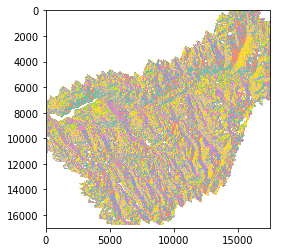

In [10]:
plt.imshow(terrain.aspect, cmap='Set2')